# Identifying features linked to attractiveness
This notebook follows on this other notebook on analysing facial ratings. The previous notebook aimed to analyse how people rate a face ; we examined 
- the distribution of averages ratings across multiple pictures
- how several variables (gender and ethnicity) correlate with the ratings
- how individual raters rate different faces
- how different people rate a same face

The above analysis was performed only on the numerical ratings given by raters to each image as well as some covariates (gender and ethnicity). For now we have not yet used the pictures themselves. In the present notebook we aim to determine which features of the images are correlated with the ratings. In a nutshell we want to find out if we can isolate:
- specific features or at least some projection from the pictures, that are characteristic of attractiveness
- specific features or at least some projection from the pictures, that are characteristic of unattractiveness

# Loading Data
First let's load the ratings and the path for each image

In [1]:


import os
from pathlib import Path
from PIL import Image
import random

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.preprocessing import StandardScaler


In [2]:

link_data = "https://github.com/fbplab/MEBeauty-database/raw/main/scores/generic_scores_all_2022.xlsx"
df = pd.read_excel(link_data)
df = df.iloc[:, 0:3] #remove individual ratings
df

,mean,image,path
0,1.117647,kuma-kum-GKbPbR0ZAT4-unsplash.jpg,/home/ubuntu/ME-beautydatabase/images/female/c...
1,1.000000,pexels-cottonbro-5529905.jpg,/home/ubuntu/ME-beautydatabase/images/male/asi...
2,1.000000,pexels-nishant-aneja-2561432.jpg,/home/ubuntu/ME-beautydatabase/images/male/ind...
3,1.428571,woman-1929550_1920.jpg,NaN
4,1.500000,pexels-himesh-mehta-3059930.jpg,/home/ubuntu/ME-beautydatabase/images/female/i...
...,...,...,...
2602,9.000000,pexels-pixabay-247322.jpg,/home/ubuntu/ME-beautydatabase/images/female/c...
2603,9.375000,women-5930352_1920.jpg,/home/ubuntu/ME-beautydatabase/images/female/a...
2604,9.222222,francesca-zama-1fhl_kmbfAE-unsplash.jpg,/home/ubuntu/ME-beautydatabase/images/female/h...
2605,9.625000,sofia--LNdco1UgNY-unsplash.jpg,/home/ubuntu/ME-beautydatabase/images/female/c...


In [3]:
# Drop  missing values if any
df.dropna(inplace=True)
df.drop("image", axis=1, inplace=True)

def standardize_path(cell):
    # We only want the architecture of the path from {gender}.
    # That way later we can provide whatever root path we want for the dataset
    path = Path(cell)
    return "/".join(path.parts[-3:])

df["path"] = df["path"].apply(standardize_path)

In [4]:
df

,mean,path
0,1.117647,female/caucasian/kuma-kum-GKbPbR0ZAT4-unsplash...
1,1.000000,male/asian/pexels-cottonbro-5529905.jpg
2,1.000000,male/indian/pexels-nishant-aneja-2561432.jpg
4,1.500000,female/indian/pexels-himesh-mehta-3059930.jpg
5,1.888889,male/asian/pexels-kaniseeyapose-2751061.jpg
...,...,...
2602,9.000000,female/caucasian/pexels-pixabay-247322.jpg
2603,9.375000,female/asian/women-5930352_1920.jpg
2604,9.222222,female/hispanic/francesca-zama-1fhl_kmbfAE-uns...
2605,9.625000,female/caucasian/sofia--LNdco1UgNY-unsplash.jpg


After removing the missing values, we have 2553 images. That's a lot of pictures ! Let's download them locally so that we can load them more easily later. You may take a cup of tea, this may take a while. Note that you may also only download the cropped dataset which is faster and takes less space on the machine.

In [5]:
import os
import requests
from tqdm import tqdm



# Function to download a file from a URL
def download_file(url, save_path):
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as file:
        for data in response.iter_content(chunk_size=1024):
            file.write(data)

# URLs of the images
base_url_original = 'https://github.com/fbplab/MEBeauty-database/raw/main/original_images/'
base_url_cropped = 'https://github.com/fbplab/MEBeauty-database/raw/main/cropped_images/images_crop_align_opencv/'

def download_dataset(df, dataset_url, output_dir, rewrite=False):
    
    image_paths = df['path'].tolist()
    with tqdm(total=len(image_paths), unit='file') as pbar:
        for  path in image_paths:
            local_path = os.path.join(output_dir, path)
            if  rewrite or not os.path.isfile(local_path):
                write_dir = os.path.join(output_dir, *Path(path).parts[:-1])
                #print(write_dir)
                os.makedirs(write_dir, exist_ok=True)
                download_file(os.path.join(dataset_url , path), local_path)
            pbar.update(1)



In [7]:

# URLs of the images
base_url_original = 'https://github.com/fbplab/MEBeauty-database/raw/main/original_images/'
base_url_cropped = 'https://github.com/fbplab/MEBeauty-database/raw/main/cropped_images/images_crop_align_opencv/'

download_dataset(df, base_url_original, 'images/original', rewrite=False)

100%|██████████████████████████████████████████████████████████████████████████| 2553/2553 [00:00<00:00, 6479.67file/s]


In [28]:
download_dataset(df, base_url_cropped, 'images/cropped', rewrite=False)

100%|████████████████████████████████████████████████████████████████████████████| 2553/2553 [25:45<00:00,  1.65file/s]


Let's have a look at the images. We will define a function to load and display a group of pictures

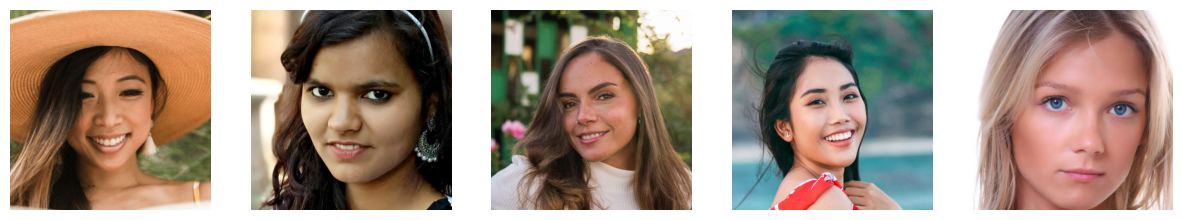

In [6]:
def load_images(dir:str, num_images:int=5)->list:
    '''
     loads a set number of random images within the directory 
    '''
    
    img_exts = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    image_paths = []
    assert os.path.isdir(dir)
    for root, dirs, files in os.walk(dir):
        for fname in files:
            if any(fname.lower().endswith(ext) for ext in img_exts):
                image_paths.append(os.path.join(root, fname))
    
    # Select a random subset of image paths
    num_images = min(num_images, len(image_paths))
                     
    selected_paths = random.sample(image_paths, num_images)
    images= []
    for image_path in selected_paths:
        image = Image.open(image_path).convert('RGB')
        images.append(image)
    
    return images

def display_images(images):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image)
        plt.axis('off')  # Hide axes
    plt.show()


# Load a few  images of women
images_dir = 'images/original/female'
images = load_images(images_dir, num_images=5)

display_images(images)

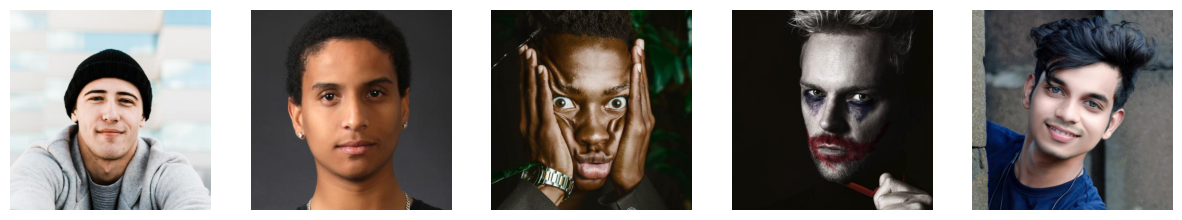

In [7]:
# Load a few  images of men
images_dir = 'images/original/male'
images = load_images(images_dir, num_images=5)

display_images(images)

Some of the images may be corrupted. Let's get rid of them before they cause us any problem downstream. It's ok, we have lots of them.

In [9]:
def is_image_loadable(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is, indeed an image
        return True
    except (IOError, SyntaxError) as e:
        print(f'Bad file: {image_path}')
        return False

def filter_corrupted_images(df, images_dir):
    df['full_path'] = df['path'].apply(lambda p: os.path.join(images_dir, p))
    df['is_valid'] = df['full_path'].apply(is_image_loadable)
    df_cleaned = df[df['is_valid']].drop(columns=['full_path', 'is_valid']).reset_index(drop=True)
    return df_cleaned


# Assuming your dataframe is named 'df' and the base path to your images is 'images_dir'
images_dir = 'images/original'
df_cleaned = filter_corrupted_images(df, images_dir )

# Check the number of images that were successfully loaded
print(f'Number of valid images: {len(df_cleaned)}')
print(f'Number of corrupted images removed: {len(df) - len(df_cleaned)}')

df = df_cleaned


Number of valid images: 2523
Number of corrupted images removed: 0


## Feature extraction
Now, since we are interested in extracting features from images, it comes to that an optimal tool for that are convolutional neural network (CNNs). This class of deep learning models  is particularly well-suited for image-related tasks due to their ability to automatically and hierarchically learn spatial hierarchies of features. In the context of identifying features linked to different levels of attractiveness, CNNs like MobileNet are especially advantageous because they can capture complex patterns and textures in images that are often crucial for subjective assessments such as attractiveness. This type of model is able to identify subtle nuances in facial features, skin texture, and other visual attributes that might correlate with perceived attractiveness.

By leveraging a pre-trained model like MobileNetV2, which have been trained on large datasets such as ImageNet (which includes among others a tremendous amount of face images), we benefit the model's prior knowledge can be adapted to our specific task. We chose MobileNetV2 since it offers a good balance between performance and computational efficiency. We will use the representation of each image given by the model to have rich high-level  features for each image. We then will be able to analyse those features. Since we only really want the learned features, we remove the last layer (classification layer)

In [10]:


# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
model.eval()



D:\Utilisateurs\souma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Utilisateurs\souma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, m

In [14]:



# Transform the image to make it suitable as input for the model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to extract features using MobileNetV2
def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    return features.flatten().numpy()
    
images_dir = "images/original"
image_paths = df["path"]
features = np.array([extract_features(os.path.join(images_dir, path)) for path in image_paths])
ratings = df["mean"].to_numpy()
features.shape, ratings.shape # features and ratings should have same length

((2523, 62720), (2523,))

## Feature Analysis
### Correlation analysis

Correlation analysis helps us understand how specific image features (extracted by a CNN) relate to attractiveness ratings. By calculating the correlation between each extracted feature and the attractiveness ratings, we can identify which features are most strongly associated with higher or lower attractiveness. Features with high positive correlations may indicate aspects that contribute to perceived attractiveness, while features with high negative correlations may indicate aspects that detract from it. In a way, we will perform feature selection (which are usually used as a step for optimisation) but here identifying the most correlated features will serve be our end goal.


We will identify the features that are most correlated (both positively and negatively) with attractiveness ratings so that we later can:

- Focus on the Most Relevant Features. Narrow down the analysis to the features that are most strongly associated with attractiveness ratings.
- Improve Interpretability: Make the results of PCA more interpretable by relating the principal components to the most influential features identified through correlation analysis.
- Enhance Visualization: Create more meaningful visualizations that highlight the key features contributing to attractiveness.


In [22]:

# Function to compute correlation 
# We will do it feature by feature to avoid using cluttering memory, since the feature matrix is quite large
def compute_feature_correlations(features, ratings):
    correlations = []
    # Compute the correlation for each feature
    for col in range(features.shape[1]):
        correlation = np.corrcoef(features[:, col], ratings)[0, 1]
        correlations.append(correlation)
        
    # Convert the list of correlations to a numpy array and return it
    return np.array(correlations)

# Calculate the correlations
correlation_values = compute_feature_correlations(features, ratings)

# Create a DataFrame with the correlation values
correlations_df = pd.DataFrame({
    'feature_index': np.arange(features.shape[1]),
    'correlation': correlation_values
})



In [41]:
# Calculate the absolute correlation values
correlations_df['abs_correlation'] = correlations_df['correlation'].abs()

# Filter the features based on the absolute correlation threshold
filtered_correlations = correlations_df[correlations_df['abs_correlation'] > 0.2]

# Display the filtered features
print("Features with an absolute correlation coefficient above 0.1:")
print(filtered_correlations)

# Select indices of the filtered features
important_feature_indices = filtered_correlations['feature_index'].tolist()
important_features = features[:, important_feature_indices]

print("Number of features selected:", len(important_feature_indices))


Features with an absolute correlation coefficient above 0.1:
       feature_index  correlation  abs_correlation
565              565    -0.220585         0.220585
653              653    -0.237493         0.237493
654              654    -0.253807         0.253807
655              655    -0.255794         0.255794
660              660    -0.251935         0.251935
...              ...          ...              ...
62425          62425     0.213621         0.213621
62437          62437     0.219016         0.219016
62443          62443     0.222660         0.222660
62444          62444     0.252682         0.252682
62451          62451     0.241108         0.241108

[2252 rows x 3 columns]
Number of features selected: 2252


## Principal Component Analysis

Explained variance ratio by each principal component:
Principal Component 1: 0.2177
Principal Component 2: 0.0398
Principal Component 3: 0.0329
Principal Component 4: 0.0216
Principal Component 5: 0.0205
Principal Component 6: 0.0191
Principal Component 7: 0.0174
Principal Component 8: 0.0158
Principal Component 9: 0.0146
Principal Component 10: 0.0144


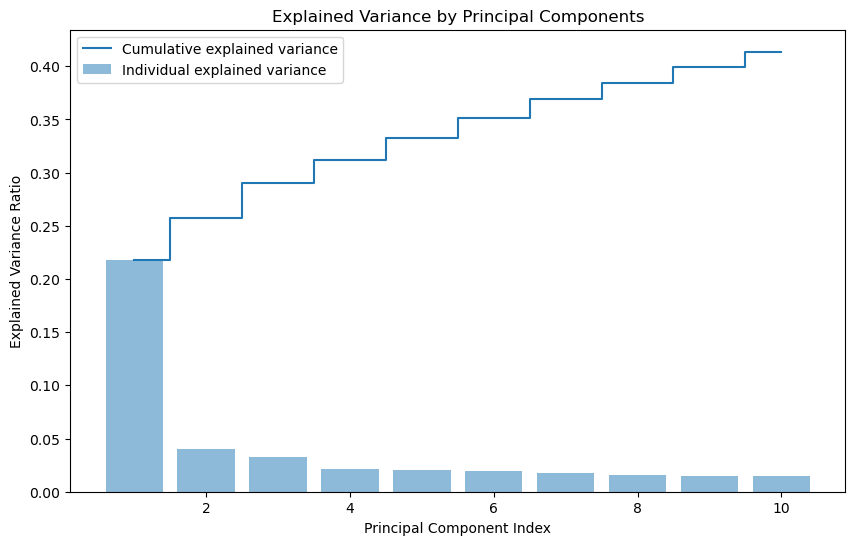

In [43]:

# Perform PCA on the important features subset
pca = PCA(n_components=10)  # Choose the number of components you want to keep
principal_components = pca.fit_transform(important_features)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Display the explained variance ratio for each component
print("Explained variance ratio by each principal component:")
for i, variance in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {variance:.4f}")

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid',
         label='Cumulative explained variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()


We see that the first component explains more than 1/5 of the variance with respects to attractiveness ratings (after trimming the features less correlated) !

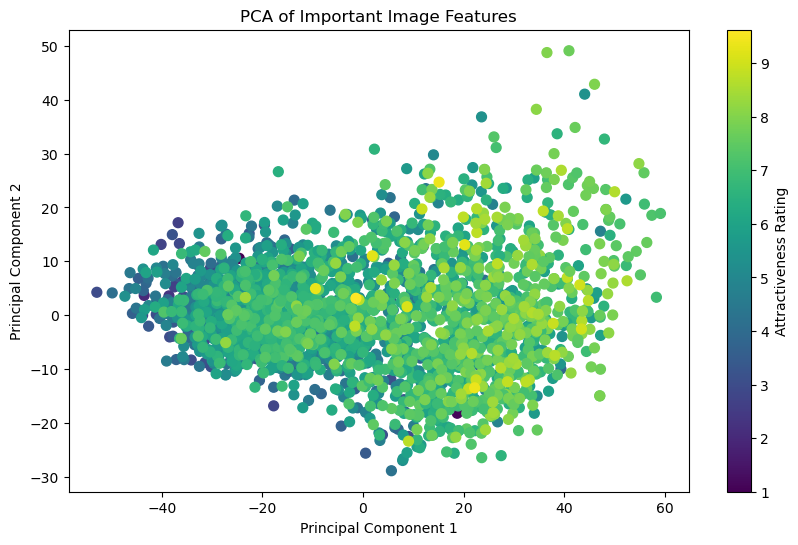

Top features contributing to PC1:
60749    0.070505
60750    0.065699
60748    0.063816
60742    0.055787
60756    0.055330
60743    0.054085
60751    0.053981
48989    0.052339
60757    0.052092
60747    0.051998
60741    0.051898
60755    0.051074
48982    0.050347
3274     0.048387
23656    0.047222
60735    0.046167
48990    0.046058
62416    0.045892
23657    0.045842
33506    0.045281
52860    0.045205
29186    0.045136
60540    0.044955
33504    0.044919
33505    0.044876
3273     0.044527
60744    0.044253
62415    0.044202
60554    0.044171
29187    0.044136
60736    0.044062
52861    0.043967
48988    0.043770
3271     0.043452
60539    0.043432
43992    0.043274
11261    0.043106
60758    0.042883
23655    0.042829
29185    0.042594
Name: PC1, dtype: float32

Top features contributing to PC2:
13310    0.076472
14829    0.075605
3274     0.075361
3270     0.074155
3281     0.070538
3277     0.070050
14830    0.069865
3275     0.066945
41877    0.065455
18063    0.065254
Name:

In [45]:



# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=ratings, cmap='viridis', s=50)
plt.colorbar(label='Attractiveness Rating')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Important Image Features')
plt.show()

# Get the loadings (contributions) of the original features to the principal components
loadings = pca.components_.T[:, :2]  # Select only the first two components

# Create a DataFrame to hold the loadings
loadings_df = pd.DataFrame(loadings, index=important_feature_indices, columns=['PC1', 'PC2'])

# Display the top contributing features for each principal component
top_pc1_features = loadings_df['PC1'].abs().sort_values(ascending=False).head(40)
top_pc2_features = loadings_df['PC2'].abs().sort_values(ascending=False).head(10)

print("Top features contributing to PC1:")
print(top_pc1_features)

print("\nTop features contributing to PC2:")
print(top_pc2_features)


## Interpreting the top features

In [48]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load pretrained MobileNetV2 model
model = mobilenet_v2(pretrained=True)

# Remove the classification layer
model.features[-1] = nn.Sequential()

# Modify the model for CAM
class CAMMobileNetV2(nn.Module):
    def __init__(self, pretrained_model):
        super(CAMMobileNetV2, self).__init__()
        self.features = pretrained_model.features
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize CAMMobileNetV2 model
cam_model = CAMMobileNetV2(model)

# Load an input image and preprocess it
image_path = images_dir +"5.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
image = cv2.resize(image, (224, 224))  # Resize to match MobileNetV2 input size
input_image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

# Forward pass the image through the CAMMobileNetV2 model
output = cam_model(input_image)

# Compute CAM heatmap
feature_map = cam_model.features(input_image)
weights = cam_model.fc.weight.squeeze()
cam_heatmap = torch.matmul(weights, feature_map.squeeze()).squeeze().detach().numpy()
cam_heatmap = cv2.resize(cam_heatmap, (image.shape[1], image.shape[0]))

# Normalize heatmap
cam_heatmap = (cam_heatmap - cam_heatmap.min()) / (cam_heatmap.max() - cam_heatmap.min())

# Overlay heatmap on input image
heatmap = cv2.applyColorMap(np.uint8(255 * cam_heatmap), cv2.COLORMAP_JET)
result_image = heatmap * 0.3 + image * 0.7
result_image = cv2.cvtColor(result_image.astype(np.uint8), cv2.COLOR_BGR2RGB)

# Display result image with heatmap
plt.imshow(result_image)
plt.axis('off')
plt.show()


ImportError: DLL load failed while importing cv2: Le module spécifié est introuvable.